# Two-Sided and One-Sided Hodrick-Prescott Filters

The code below implements the classical two-sided Hodrick-Prescott filter as well as the newer one-sided version.

We recommend the following literature to understand the filters:
- Hodrick R.J., Prescott E.C. (1997): "Postwar U.S. business cycles: An empirical investigation", Journal of Money, Credit and Banking, 29(1), 1–16
- Wolf E., Mokinski F., Schüler Y. (2020): "On adjusting the one-sided Hodrick-Prescott filter", Deutsche Bundesbank, Discussion Paper No 11/2020

Below the implementations as Python functions. These are non-optimized functions for educational purposes.

In [1]:
import numpy as np
from scipy.sparse import diags
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

def apa_hpfilter(X, lamb=1600):
    X = np.atleast_2d(X)
    n_obs, n_series = X.shape
    diagonals = [np.ones(n_obs), -2 * np.ones(n_obs - 1), np.ones(n_obs - 2)]
    D = diags(diagonals, [0, 1, 2], shape=(n_obs - 2, n_obs)).toarray()
    penalty = lamb * (D.T @ D)
    A = np.eye(n_obs) + penalty
    trend = np.zeros_like(X)
    for i in range(n_series):
        trend[:, i] = np.linalg.solve(A, X[:, i])
    return trend

def apa_hpfilter_onesided(X, lamb=1600):
    X = np.atleast_2d(X)
    n_obs, n_series = X.shape
    trend = np.zeros_like(X)
    for t in range(2, n_obs):
        xt = X[:t+1, :]
        diagonals = [np.ones(t+1), -2 * np.ones(t), np.ones(t-1)]
        D = diags(diagonals, [0,1,2], shape=(t-1, t+1)).toarray()
        penalty = lamb * (D.T @ D)
        A = np.eye(t+1) + penalty
        for i in range(n_series):
            tr = np.linalg.solve(A, xt[:, i])
            trend[t, i] = tr[-1]
    trend[0, :] = X[0, :]
    if n_obs > 1:
        trend[1, :] = X[1, :]
    return trend

Let us get some data in order to illustrate the usage of these functions and set the necessary parameters

In [2]:
start_obs = 20 # e.g., start at row 20 (set as desired)
step_size = 5 # set to your preferred step, e.g. weekly = 5 if the data is daily
lambda_twosided = 400
lambda_onesided = 16*lambda_twosided # is usually arger, because the one-sided filter makes use of less observations

Now let us load some data and select one time series.

In [3]:
xraw = pd.read_csv("data.csv", index_col=0, parse_dates=True)

# chain-linking the returns
xchainlinked = (1 + xraw).cumprod()

# select one time series
idx = 10
xselected = xchainlinked.iloc[:, idx-1].values # Python is 0-based

Determine the number of observations we have.

In [4]:
n_obs = len(xselected)
print(n_obs)

487


Now apply the functions and plot the results.

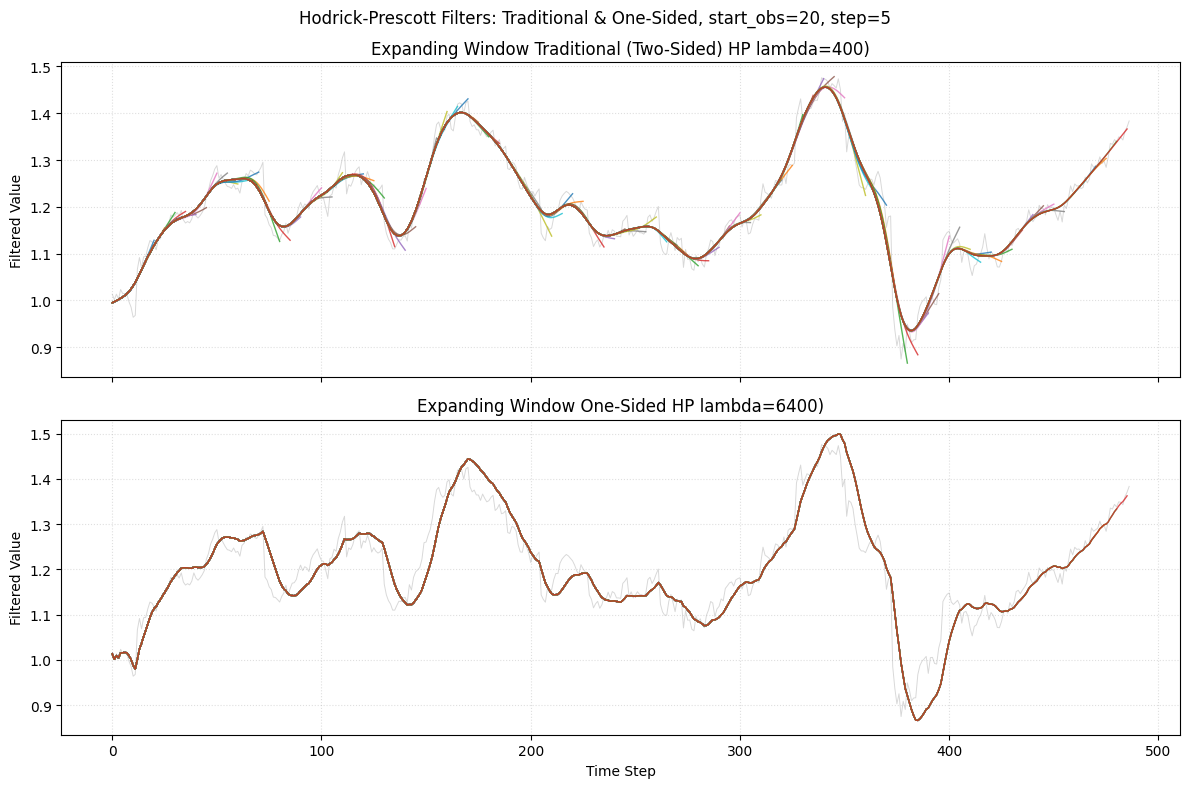

In [10]:
# Prepare subplot
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# 1. Traditional HP filter, rolling expansions
for i in range(start_obs, n_obs, step_size):
    x_win = xselected[:i+1]
    # HP expects 2D, so add axis
    trend_trad = apa_hpfilter(x_win[:, None], lambda_twosided).flatten()
    axs[0].plot(np.arange(i+1), trend_trad, alpha=0.8, lw=1)

axs[0].plot(np.arange(n_obs), xselected, color="grey", lw=0.7, label="Chain-linked original", zorder=-1, alpha=0.3)
axs[0].set_title(f"Expanding Window Traditional (Two-Sided) HP lambda={lambda_twosided})")
axs[0].set_ylabel("Filtered Value")
axs[0].grid(True, linestyle=":", alpha=0.4)

# 2. One-sided HP filter, same windows
for i in range(start_obs, n_obs, step_size):
    x_win = xselected[:i+1]
    trend_onesided = apa_hpfilter_onesided(x_win[:, None], lambda_onesided).flatten()
    axs[1].plot(np.arange(i+1), trend_onesided, alpha=0.8, lw=1)

axs[1].plot(np.arange(n_obs), xselected, color="grey", lw=0.7, label="Chain-linked original", zorder=-1, alpha=0.3)
axs[1].set_title(f"Expanding Window One-Sided HP lambda={lambda_onesided})")
axs[1].set_ylabel("Filtered Value")
axs[1].set_xlabel("Time Step")
axs[1].grid(True, linestyle=":", alpha=0.4)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.suptitle(f"Hodrick-Prescott Filters: Traditional & One-Sided, start_obs={start_obs}, step={step_size}")
plt.show()